Obtain forecasts for Trajectron on CARLA (or NuScenes) data.

In [3]:
%matplotlib inline

import os
import sys
sys.path.append('../../trajectron')
sys.path.append(f"{ os.environ['HOME'] }/code/robotics/carla-collect")
sys.path.append(f"{ os.environ['HOME'] }/src/carla/PythonAPI/carla/dist/carla-0.9.11-py3.7-linux-x86_64.egg")

import numpy as np
import torch
import dill
import json
from glob import glob
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe

from helper import *
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 5) % len(AGENT_COLORS) for i in range(17)], 0)

NCOLORS = len(AGENT_COLORS)

class NumpyEncoder(json.JSONEncoder):
    """
    Custom encoder for numpy data types obtained from
    https://stackoverflow.com/questions/50916422/python-typeerror-object-of-type-int64-is-not-json-serializable
    """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex_, np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)): 
            return None

        return json.JSONEncoder.default(self, obj)

def get_ego_node(nodes):
    nodes = filter(lambda k: 'VEHICLE/ego' in repr(k), nodes)
    return next(nodes)

def get_scene(s):
    sel_scenes = list(filter(lambda scene : scene.name in [s], eval_scenes))
    print(sel_scenes)
    scene = sel_scenes[0]
    return scene

In [4]:
# Search dataset
dataset_dir = f"{ os.environ['HOME'] }/code/robotics/carla-collect/carla_v2_1_dataset"
glob(f"{ dataset_dir }/*.pkl")

['/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_val_v2_1_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_test_v2_1_full.pkl',
 '/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_train_v2_1_full.pkl']

In [5]:
# Load dataset
dataset_path = f"{ dataset_dir }/carla_test_v2_1_full.pkl"
with open(dataset_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

In [6]:
# Search models
os.listdir("models")

['vel_ee',
 'models_27_May_2021_18_18_30_carla_v1',
 'models_19_Mar_2021_00_31_28_int_ee_ph8',
 'models_17_Mar_2021_19_17_00_robot',
 'robot',
 'models_02_Mar_2021_22_37_40_int_ee',
 '20210622',
 'models_17_Mar_2021_19_20_17_int_ee',
 'int_ee',
 'models_25_Feb_2021_16_15_46_robot',
 'models_19_Mar_2021_00_35_20_vel_ee_ph8',
 'models_17_Mar_2021_19_29_17_vel_ee',
 'int_ee_me',
 'models_28_May_2021_13_36_24_carla_v1',
 'models_02_Mar_2021_17_44_10_vel_ee',
 'models_27_May_2021_18_04_21_carla_v1',
 '20210603',
 '20210610',
 'models_18_Mar_2021_22_50_37_int_ee_me',
 'models_19_Mar_2021_22_14_40_int_ee_me']

In [7]:
# Load model
model_dir = 'models/20210622'
# model_name = 'models_02_Jun_2021_17_01_00_carla_v2'
# model_name = 'models_06_Jun_2021_17_02_01_carla_v2_K12'
model_name = 'models_19_Mar_2021_22_14_19_int_ee_me_ph8'

model_path = os.path.join(model_dir, model_name)
eval_stg, hyp = load_model(
    model_path, eval_env, ts=20)#, device='cuda:0')


Loading from models/20210622/models_19_Mar_2021_22_14_19_int_ee_me_ph8/model_registrar-20.pt
Loaded!



### Combining forecast and map

In [13]:
# TRAIN SET
t = 12
scene = eval_scenes[30]
ph = 8
num_samples = 100
timesteps = np.array([t])

In [26]:
# TEST SET
t = 1
scene = eval_scenes[120]
ph = 8
num_samples = 10
timesteps = np.array([t])

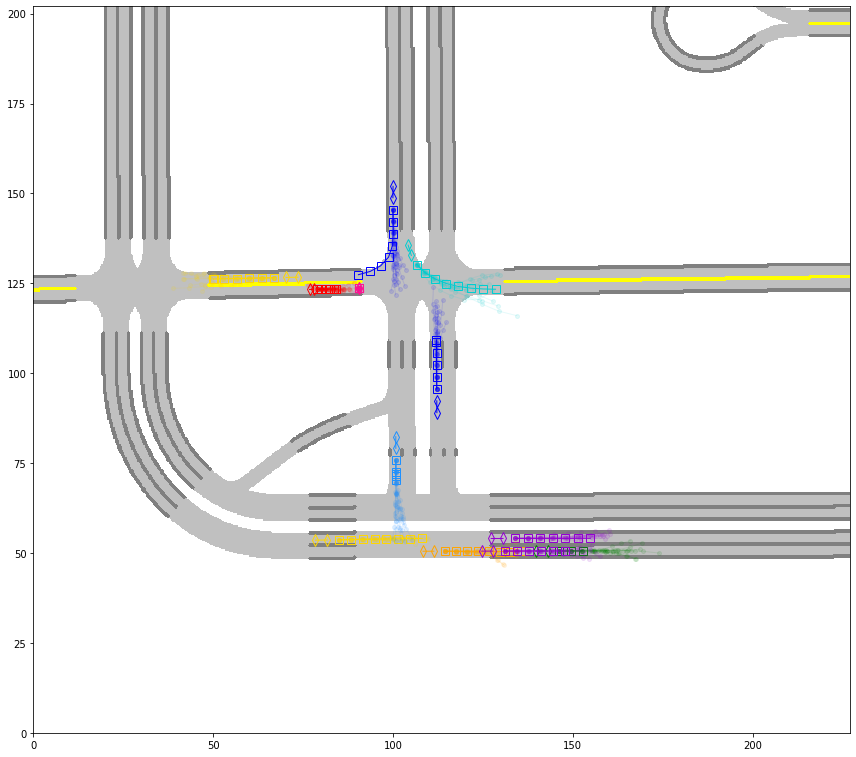

In [27]:
with torch.no_grad():
    # eval_stg the model interface
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=False,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
node = v_nodes[0]

map_mask = scene.map['VISUALIZATION'].as_image()
# map_mask has shape (y, x, c)
road_bitmap = np.max(map_mask, axis=2)
road_div_bitmap = map_mask[..., 1]
lane_div_bitmap = map_mask[..., 0]

fig, ax = plt.subplots(figsize=(12,15))
extent = (scene.x_min, scene.x_max, scene.y_min, scene.y_max)
extent = (0, scene.x_size, 0, scene.y_size)
# Axes.imshow() expects (y, x, c)
ax.imshow(road_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'grey']))
ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))

for idx, node in enumerate(v_nodes):
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]

    ax.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    ax.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        ax.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, alpha=0.1, markersize=4)

ax.set_xlim([0, scene.x_size])
ax.set_ylim([0, scene.y_size])
fig.tight_layout()

# fn = f"predict_scene{scene.name}_t{timesteps[0]}_overhead.png"
# fp = os.path.join('plots', fn)
# fig.savefig(fp)
None

### Latents to forecasts

### Plot predictions by latent

In [61]:
def generate_vehicle_latents(
            num_samples = 200,
            z_mode=False, gmm_mode = False, full_dist = False, all_z_sep = False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)

    model.latent.p_dist = model.p_z_x(mode, x)
    latent_probs = model.latent.get_p_dist_probs() \
            .cpu().detach().numpy()
    latent_probs = np.squeeze(latent_probs)

    z, num_samples, num_components = model.latent.sample_p(num_samples,
                                                          mode,
                                                          most_likely_z=z_mode,
                                                          full_dist=full_dist,
                                                          all_z_sep=all_z_sep)
    
    _, predictions = model.p_y_xz(mode, x, x_nr_t, y_r, n_s_t0, z,
                                            prediction_horizon,
                                            num_samples,
                                            num_components,
                                            gmm_mode)
    z = z.cpu().detach().numpy()
    zz = z
    # z has shape (number of samples, number of vehicles, number of latent values)
    # z[i,j] gives the latent for sample i of vehicle j
#     print(z.shape)
    
    predictions = predictions.cpu().detach().numpy()
    # predictions has shape (number of samples, number of vehicles, prediction horizon, D)
#     print(predictions.shape)

    predictions_dict = dict()
    for i, ts in enumerate(timesteps_o):
        if ts not in predictions_dict.keys():
            predictions_dict[ts] = dict()
        predictions_dict[ts][nodes[i]] = np.transpose(predictions[:, [i]], (1, 0, 2, 3))
    
    z = np.swapaxes(np.argmax(z, axis=-1), 0, 1)
    predictions = np.swapaxes(predictions, 0, 1)
        
    return z, zz, predictions, nodes, predictions_dict, latent_probs

def plot_behavior(scene, z, predictions, nodes):
#     coords = predictions.reshape(-1, 2)
#     x_max, y_max = np.amax(coords, axis=0)
#     x_min, y_min = np.amin(coords, axis=0)
    figwidth  = 20.
#     figheight = figwidth*(13. / 2.)*(y_max - y_min)/(x_max - x_min)
    figheight = figwidth*(13. / 2.)*(scene.y_size)/(scene.x_size)
    
    _, histories_dict, _ = \
            prediction_output_to_trajectories(
                predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)
    
    n_vehicles = len(nodes)
    colors = cm.nipy_spectral(np.linspace(0, 1, 25))
    fig, axes = plt.subplots(13, 2,
            figsize=(figwidth, figheight))
    fig.tight_layout()
    
    for behavior in range(0, 25):
        ax = axes[behavior // 2][behavior % 2]
        color = colors[behavior]
        label=f"z = {behavior}"
        for idx, node in enumerate(nodes):
            zn = z[idx]
            pn = predictions[idx]
            mask = zn == behavior
            zn = zn[mask]
            pn = pn[mask]
            player_past = histories_dict[t][node]
            player_past = np.vstack(
                    (player_past, player_past[-1][None] + 5))
            
            ax.plot(player_past[:,0], player_past[:,1],
                    color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1)
            
            for jdx in range(zn.shape[0]):
                ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                        marker='o', color=color,
                        linewidth=1, alpha=0.2, markersize=4,
                        label=label)
                label=None
#         ax.set_xlim([x_min, x_max])
#         ax.set_ylim([y_min, y_max])
        ax.set_xlim([0, scene.x_size])
        ax.set_ylim([0, scene.y_size])
        ax.set_aspect('equal')
        ax.legend(loc='upper right')
        ax.set_facecolor("grey")
#     axes[-1,-1].set_xlim([x_min, x_max])
#     axes[-1,-1].set_ylim([y_min, y_max])
    axes[-1,-1].set_xlim([0, scene.x_size])
    axes[-1,-1].set_ylim([0, scene.y_size])
    axes[-1,-1].set_visible(False)
    return fig, axes

In [62]:
with torch.no_grad():
    z,zz, predictions, nodes, predictions_dict, latent_probs = generate_vehicle_latents(
            num_samples=500,
            z_mode=False, gmm_mode = False,
            full_dist = False, all_z_sep = False)

12
VEHICLE/392
VEHICLE/ego
VEHICLE/463
VEHICLE/460
VEHICLE/434
VEHICLE/425
VEHICLE/455
VEHICLE/417
VEHICLE/407
VEHICLE/404
VEHICLE/393
VEHICLE/421


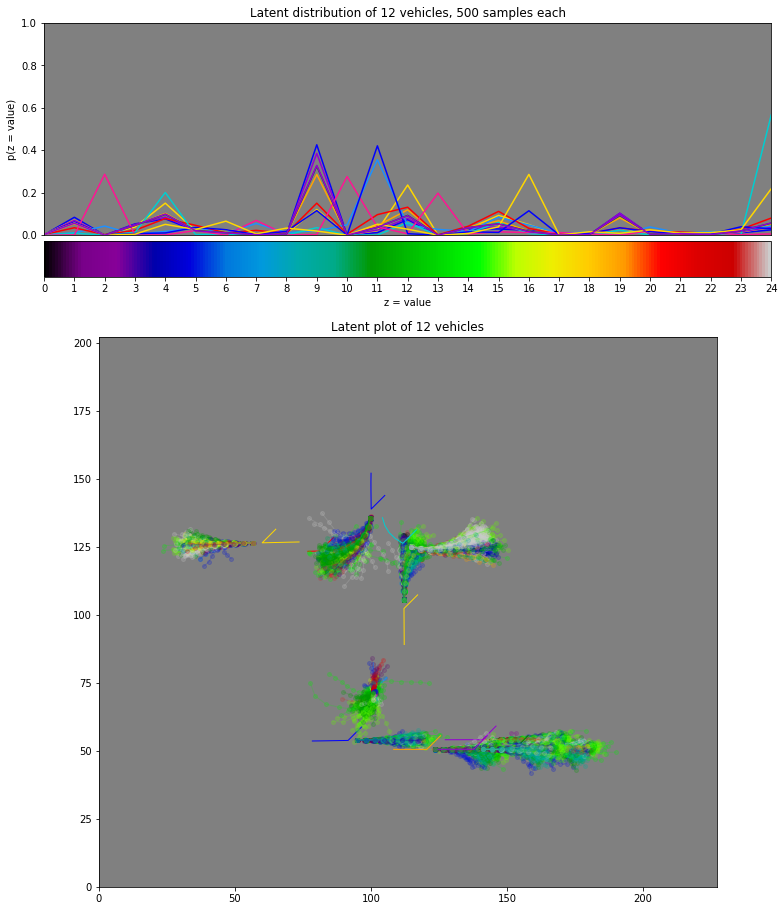

In [63]:
latent_size = zz.shape[2]
latent_colors = cm.nipy_spectral(np.linspace(0, 1, latent_size))
z_counts = np.sum(zz, axis=0) / z.shape[1]
n_vehicles = len(nodes)
print(n_vehicles)

_, histories_dict, _ = \
    prediction_output_to_trajectories(
        predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)

fig, (ax1, ax) = plt.subplots(2, 1, figsize=(11, 16))
fig.tight_layout()

ax1.set_facecolor("grey")
for idx, v_probs in enumerate(latent_probs):
    ax1.plot(range(latent_size), v_probs, c=AGENT_COLORS[idx % NCOLORS])
ax1.set_xlim([0, latent_size - 1])
ax1.set_ylim([0, 1])
ax1.set_aspect(7)
ax1.set_ylabel("p(z = value)")
ax1.set_title(f"Latent distribution of {n_vehicles} vehicles, {z.shape[1]} samples each")
ax1.get_xaxis().set_ticks([])

scalarmappaple = cm.ScalarMappable(cmap=cm.nipy_spectral)
scalarmappaple.set_array(range(0, latent_size))
plt.colorbar(scalarmappaple, ax=ax1, orientation='horizontal',
             pad=0.01,
             ticks=range(0, 25),
             label="z = value")

for idx, node in enumerate(nodes):
    print(node)
    player_past = histories_dict[t][node]
    player_past = np.vstack((player_past, player_past[-1][None] + 5))

    ax.plot(player_past[:,0], player_past[:,1],
            color=AGENT_COLORS[idx % NCOLORS],
            linewidth=1)

    # latent variable z corresponding to vehicle.
    zn = z[idx]
    pn = predictions[idx]
    for jdx in range(zn.shape[0]):
        color = latent_colors[zn[jdx]]
        ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                marker='o',
                 color=color,
                linewidth=1, alpha=0.2, markersize=4)

ax.set_facecolor("grey")
ax.set_title(f"Latent plot of {n_vehicles} vehicles")
ax.set_aspect('equal')
ax.set_xlim([0, scene.x_size])
ax.set_ylim([0, scene.y_size])
fig.tight_layout()

# fn = f"predict_scene{scene.name}_t{timesteps[0]}_comb_latents.png"
# fp = os.path.join('plots', fn)
# fig.savefig(fp)

KeyError: 0

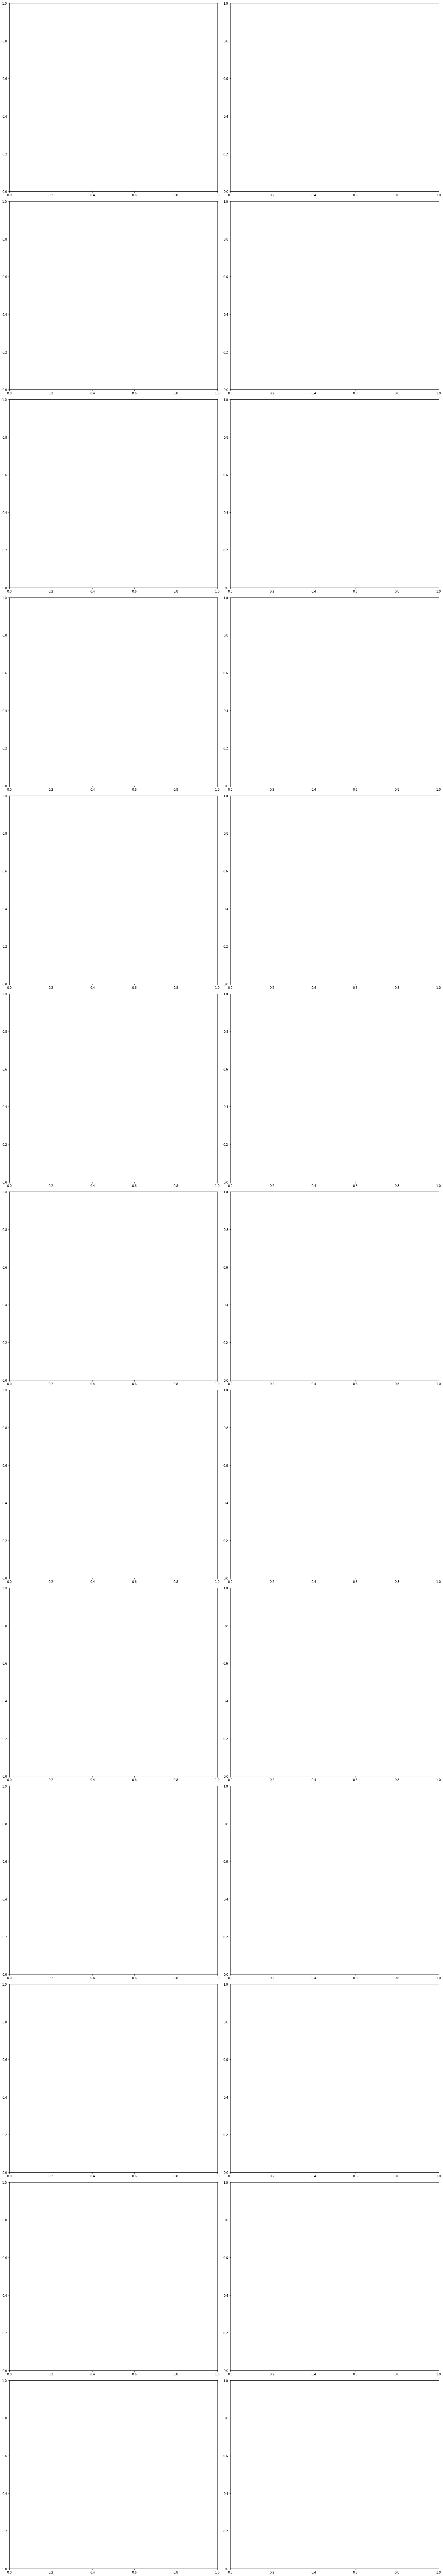

In [68]:
fig, ax = plot_behavior(scene, z, predictions, nodes)
# fn = f"predict_scene{scene.name}_t{timesteps[0]}_each_latents.png"
# fp = os.path.join('plots', fn)
# fig.savefig(fp)